<a href="https://colab.research.google.com/github/quocthescaredycat/imdb-sentiment-analysis/blob/main/RNN_LSTM_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
if not os.path.exists('IMDB Dataset.csv'):
    !gdown 1Sm8UZ-JZBjw-xBCUb3_-AmTlwPGd6RBi

Downloading...
From: https://drive.google.com/uc?id=1Sm8UZ-JZBjw-xBCUb3_-AmTlwPGd6RBi
To: /content/IMDB Dataset.csv
100% 66.2M/66.2M [00:01<00:00, 49.9MB/s]


In [ ]:
!pip install unidecode
!pip install contractions
!pip install tokenizers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.4 MB/s eta 0:00:00


# **Import Library**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import unidecode
import string
import contractions
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
import html
from sklearn.metrics import f1_score, precision_score, recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Load Dataset**

In [ ]:
df = pd.read_csv('./IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
print(f'Number of Null value: {df.isnull().sum().values.sum()}')
print(f'Number of positive Sentiment {sum(df['sentiment'] == 'positive')}')
print(f'Number of negative Sentiment {sum(df['sentiment'] == 'negative')}')

Number of Null value: 0
Number of positive Sentiment 25000
Number of negative Sentiment 25000


In [ ]:
X = df['review'].values
y = df['sentiment'].values
y = [1 if label == 'positive' else 0 for label in y]
n_classes = len(set(y))
n_classes

2

# **Text Preprocessing & Tokenization**


In [ ]:
english_stop_words = stopwords.words('english')
english_stop_words.remove('not')
stemmer = PorterStemmer()
def normalize_text(text):
  text = text.lower()
  text = unidecode.unidecode(text)
  text = text.strip()
  #Remove Contractions
  text = contractions.fix(text)
  #Remove HTML tags
  text = re.sub(r'<.*?>','',text)
  #Remove punctuation
  text = text.translate(str.maketrans('','',string.punctuation))
  tokens = text.split()
  #Remove stopwords
  text = ' '.join([word for word in tokens if word not in english_stop_words])
  #Stemming(return to root form)
  text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
  tokens = text.split(' ')
  return tokens
corpus = [normalize_text(text) for text in X]

# **Vocabulary Creation**

In [ ]:
def create_vocabulary(corpus):
  vocab_freq = defaultdict(int)
  for tokens in corpus:
    for token in tokens:
      vocab_freq[token] +=1
  print(len(vocab_freq))
  sorted_vocab = sorted(vocab_freq.items(), key=lambda x: x[1], reverse=True)
  vocab = [word[0] for word in sorted_vocab[:10000]]
  vocab.append('<UNK>')
  vocab.append('<PAD>')
  return vocab

vocab = create_vocabulary(corpus)

180689


# **Text Vectorization & Padding**

In [ ]:
max_seq_len = int(np.percentile([len(tokens) for tokens in corpus], 95) + 1)
word_2_idx = {word:idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)
print(f"Vocabulary size: {len(word_2_idx)}")
print(f"Maximum sequence length: {max_seq_len}")
def Corpus_vectorization(corpus, max_seq_len, word_2_idx):
    """
    Convert text corpus to numerical sequences for neural network input.

    Args:
        corpus: List of tokenized texts
        max_seq_len: Maximum sequence length for padding
        word_2_idx: Dictionary mapping words to indices

    Returns:
        List of numerical sequences (padded to max_seq_len)
    """
    vectorize_corpus = []
    for tokens in corpus:
        vectorize_tokens = []
        for token in tokens:
            if len(vectorize_tokens) == max_seq_len:
                break
            if token not in word_2_idx:
                vectorize_tokens.append(word_2_idx['<UNK>'])  # Unknown word
            else:
                vectorize_tokens.append(word_2_idx[token])
        while len(vectorize_tokens) < max_seq_len:
            vectorize_tokens.append(word_2_idx['<PAD>'])
        vectorize_corpus.append(vectorize_tokens)
    return vectorize_corpus
vectorize_corpus = Corpus_vectorization(corpus, max_seq_len, word_2_idx)

Vocabulary size: 10002
Maximum sequence length: 310


# **Data Preprocessing for Transformer**

In [ ]:
def text_clean(text):
    text = str(text)
    text = html.unescape(text)
    text = re.sub(r'<.*?>', ' ', text)
    text = unidecode.unidecode(text)
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'([.,!?])', r' \1 ', text)
    text = re.sub(r'[^a-z0-9\s.,!?\'-]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

X_clean = [text_clean(text) for text in X]

tokenizer = Tokenizer(BPE(unk_token="<UNK>"))
tokenizer.pre_tokenizer = Whitespace()

trainer = BpeTrainer(
    vocab_size=25000,
    min_frequency=2,
    special_tokens=["<PAD>", "<UNK>"]
)

tokenizer.train_from_iterator(X_clean, trainer)
vocab_size = tokenizer.get_vocab_size()
pad_token_id = tokenizer.token_to_id("<PAD>")
print(f"Vocab Size: {vocab_size}, PAD ID: {pad_token_id}")
tokenizer_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/IMDBdataset", "tokenizer.json")
tokenizer.save(tokenizer_path)

Vocab Size: 25000, PAD ID: 0


In [ ]:
seq_lens = [len(tokenizer.encode(x).ids) for x in X_clean]

# Statistics
print(f"Average length: {np.mean(seq_lens)}")
print(f"Max length: {np.max(seq_lens)}")
print(f"Length covering 95% of data: {np.percentile(seq_lens, 95)}")
print(f"Length covering 99% of data: {np.percentile(seq_lens, 99)}")

Average length: 273.01138
Max length: 2972
Length covering 95% of data: 700.0
Length covering 99% of data: 1065.010000000002


In [ ]:
max_seq_len = 512
tokenizer.enable_padding(pad_id=pad_token_id, pad_token="<PAD>", length=max_seq_len)
tokenizer.enable_truncation(max_length=max_seq_len)
X_vec = [e.ids for e in tokenizer.encode_batch(X_clean)]
X_vec = np.array(X_vec)

# **IMDB Dataset**

In [ ]:
class ImdbDataset(Dataset):
  def __init__(self,X,y):
    self.data = X
    self.label = y
  def __len__(self):
    return len(self.label)
  def __getitem__(self, idx):
    return torch.tensor(self.data[idx],dtype=torch.long),torch.tensor(self.label[idx],dtype=torch.long)

# **RNN**

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, n_classes, dropout):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, hidden = self.rnn(embedded)
        last_hidden = hidden[-1]
        out = self.dropout(last_hidden)
        logits = self.fc(out)
        return logits

# **LSTM**

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout):
        super(LSTMClassifier,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 2)
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        last_hidden = hidden[-1]
        dropped = self.dropout(last_hidden)
        output = self.fc(dropped)
        return output

# **Transformer**

In [ ]:
class EncoderBlock(nn.Module):
  def __init__(self,embed_dim,num_heads,dropout):
    super().__init__()
    self.attn = nn.MultiheadAttention(embed_dim,num_heads,dropout,batch_first=True)
    self.norm1 = nn.LayerNorm(embed_dim)
    self.dropout = nn.Dropout(dropout)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.ffwd = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Linear(embed_dim * 2, embed_dim)
        )
  def forward(self,x,src_key_padding_mask=None):
    skip = x
    x,_ = self.attn(x,x,x, key_padding_mask=src_key_padding_mask) #output, weight
    x = self.norm1(skip+self.dropout(x))
    skip = x
    x = self.ffwd(x)
    x = self.norm2(skip+self.dropout(x))
    return x

class TransformerEncoder(nn.Module):
  def __init__(self,vocab_size,max_seq_len,embed_dim,num_heads,num_blocks,dropout,n_classes, pad_idx):
    super().__init__()
    self.pad_idx = pad_idx
    self.embed_matrix = nn.Embedding(num_embeddings=vocab_size,embedding_dim=embed_dim, padding_idx=pad_idx)

    self.register_buffer('positional_encoding', self._create_pos_encoding(max_seq_len, embed_dim))
    self.dropout = nn.Dropout(dropout)
    self.encoder_layers = nn.ModuleList([])
    for i in range(num_blocks):
      self.encoder_layers.append(EncoderBlock(embed_dim,num_heads,dropout))
    self.ffwd = nn.Linear(embed_dim,embed_dim*2)
    self.relu = nn.ReLU()
    self.out = nn.Linear(embed_dim*2,n_classes)

  def _create_pos_encoding(self, max_len, embed_dim):
    pe = torch.zeros(max_len, embed_dim)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)

  def forward(self,x):
    # BxS
    padding_mask = (x == self.pad_idx)
    seq_len = x.size(1)
    x = self.embed_matrix(x)* math.sqrt(self.embed_matrix.embedding_dim)
    x = x + self.positional_encoding[:, :seq_len, :]
    x = self.dropout(x)
    for layer in self.encoder_layers:
      x = layer(x, src_key_padding_mask=padding_mask)
    mask_float = (~padding_mask).float().unsqueeze(-1)
    x = x*mask_float
    sum_embedings = torch.sum(x, dim=1)
    count_tokens = torch.sum(mask_float, dim=1).clamp(min=1)
    mean_pooling = sum_embedings/ count_tokens
    x = self.ffwd(mean_pooling)
    x = self.relu(x)
    return self.out(x)

# **Training**

In [ ]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    batch_val_loss = []
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_val_loss.append(criterion(outputs, labels).item())
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    epoch_val_loss = sum(batch_val_loss) / len(batch_val_loss)
    val_acc = np.mean(np.array(all_preds) == np.array(all_targets))
    val_f1 = f1_score(all_targets, all_preds, average='binary')
    val_precision = precision_score(all_targets, all_preds, average='binary')
    val_recall = recall_score(all_targets, all_preds, average='binary')

    return epoch_val_loss, val_acc, val_f1, val_precision, val_recall

def fit(model, criterion, optimizer, train_loader, val_loader, num_epochs, patience, device, save_path="/content/drive/MyDrive/Colab Notebooks/IMDBdataset", name='best_model.pt'):
    epoch_train_loss = []
    epoch_train_acc = []
    epoch_val_loss = []
    epoch_val_acc = []

    best_val_loss = 1000
    early_stop_count = 0
    patience = patience

    for epoch in range(num_epochs):
        model.train()
        batch_train_loss, batch_train_acc, count = [], [], 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            batch_train_loss.append(loss.item())
            batch_train_acc.append(torch.sum(torch.argmax(outputs, dim=1) == labels).item())
            count += len(labels)

        train_loss = sum(batch_train_loss) / len(batch_train_loss)
        train_acc = sum(batch_train_acc) / count
        val_loss, val_acc, val_f1, val_prec, val_rec = evaluate(model, val_loader, criterion, device)
        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'  Train Acc:  {train_acc:.4f} | Val Acc:  {val_acc:.4f}')
        print(f'  Val F1:     {val_f1:.4f}   | Val P:    {val_prec:.4f} | Val R: {val_rec:.4f}')
        print("-" * 50)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_count = 0
            torch.save(model.state_dict(), os.path.join(save_path, name))
        else:
            early_stop_count += 1

        if early_stop_count == patience:
            break

    model.load_state_dict(torch.load(os.path.join(save_path, name), map_location=device))

    return epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64
embed_dim = 128
hidden_dim = 128
num_layers = 1
n_classes = 2
dropout = 0.5
learning_rate = 0.001
num_epochs = 20

X_train, X_temp, y_train, y_temp = train_test_split(vectorize_corpus, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

train_dataset = ImdbDataset(X_train, y_train)
val_dataset = ImdbDataset(X_val, y_val)
test_dataset = ImdbDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model = RNNClassifier(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    n_classes=n_classes,
    dropout=dropout
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc = fit(
    model, criterion, optimizer, train_loader, val_loader, num_epochs, 10, device, name='rnn.pt')

Epoch 1/20:
  Train Loss: 0.7015 | Val Loss: 0.6933
  Train Acc:  0.5033 | Val Acc:  0.4996
  Val F1:     0.0915   | Val P:    0.5972 | Val R: 0.0495
--------------------------------------------------
Epoch 2/20:
  Train Loss: 0.6946 | Val Loss: 0.6930
  Train Acc:  0.5038 | Val Acc:  0.5084
  Val F1:     0.6724   | Val P:    0.5086 | Val R: 0.9921
--------------------------------------------------
Epoch 3/20:
  Train Loss: 0.6949 | Val Loss: 0.6952
  Train Acc:  0.5057 | Val Acc:  0.4962
  Val F1:     0.5056   | Val P:    0.5047 | Val R: 0.5065
--------------------------------------------------
Epoch 4/20:
  Train Loss: 0.7002 | Val Loss: 0.6944
  Train Acc:  0.5008 | Val Acc:  0.4960
  Val F1:     0.0611   | Val P:    0.5816 | Val R: 0.0322
--------------------------------------------------
Epoch 5/20:
  Train Loss: 0.6988 | Val Loss: 0.6936
  Train Acc:  0.5022 | Val Acc:  0.4970
  Val F1:     0.5221   | Val P:    0.5051 | Val R: 0.5403
----------------------------------------------

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
embed_dim = 128
hidden_dim = 128
num_layers = 2
dropout = 0.2
num_epochs = 8
X_train, X_test, y_train, y_test = train_test_split(vectorize_corpus, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
train_dataset = ImdbDataset(X_train,y_train)
val_dataset = ImdbDataset(X_val, y_val)
test_dataset = ImdbDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

lstm_model = LSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)

epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc = fit(
    lstm_model, criterion, optimizer, train_loader, val_loader, num_epochs, 3, device, name='lstm.pt')

Epoch 1/8:
  Train Loss: 0.6937 | Val Loss: 0.6929
  Train Acc:  0.4989 | Val Acc:  0.4993
  Val F1:     0.6658   | Val P:    0.4993 | Val R: 0.9987
--------------------------------------------------
Epoch 2/8:
  Train Loss: 0.6907 | Val Loss: 0.6935
  Train Acc:  0.5051 | Val Acc:  0.5024
  Val F1:     0.6652   | Val P:    0.5009 | Val R: 0.9898
--------------------------------------------------
Epoch 3/8:
  Train Loss: 0.6699 | Val Loss: 0.6386
  Train Acc:  0.5485 | Val Acc:  0.6673
  Val F1:     0.6253   | Val P:    0.7145 | Val R: 0.5559
--------------------------------------------------
Epoch 4/8:
  Train Loss: 0.4869 | Val Loss: 0.4332
  Train Acc:  0.7728 | Val Acc:  0.8153
  Val F1:     0.7961   | Val P:    0.8873 | Val R: 0.7219
--------------------------------------------------
Epoch 5/8:
  Train Loss: 0.2942 | Val Loss: 0.3455
  Train Acc:  0.8832 | Val Acc:  0.8611
  Val F1:     0.8607   | Val P:    0.8621 | Val R: 0.8594
--------------------------------------------------


**Transformer**

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
batch_size = 64
embed_dim = 256
num_heads = 4
num_blocks = 2
dropout=0.1
num_epochs = 10
learning_rate = 5e-4
X_train,X_test,y_train,y_test = train_test_split(X_vec,y,test_size=0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.1)
train_dataset = ImdbDataset(X_train,y_train)
val_dataset = ImdbDataset(X_val,y_val)
test_dataset = ImdbDataset(X_test,y_test)
train_loader = DataLoader(train_dataset,batch_size,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size)
test_loader = DataLoader(test_dataset,batch_size)
model = TransformerEncoder(vocab_size,max_seq_len,embed_dim,num_heads,num_blocks,dropout,n_classes,pad_token_id).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.9)
epoch_train_loss,epoch_train_acc,epoch_val_loss,epoch_val_acc = fit(model,criterion,optimizer,
                                                                    train_loader,val_loader,num_epochs,10,device,name='transformer.pt')



Epoch 1/10:
  Train Loss: 0.4702 | Val Loss: 0.4037
  Train Acc:  0.7712 | Val Acc:  0.8090
  Val F1:     0.8140   | Val P:    0.8261 | Val R: 0.8023
--------------------------------------------------
Epoch 2/10:
  Train Loss: 0.3809 | Val Loss: 0.3678
  Train Acc:  0.8300 | Val Acc:  0.8390
  Val F1:     0.8379   | Val P:    0.8814 | Val R: 0.7985
--------------------------------------------------
Epoch 3/10:
  Train Loss: 0.3471 | Val Loss: 0.3524
  Train Acc:  0.8471 | Val Acc:  0.8420
  Val F1:     0.8526   | Val P:    0.8294 | Val R: 0.8772
--------------------------------------------------
Epoch 4/10:
  Train Loss: 0.3253 | Val Loss: 0.3309
  Train Acc:  0.8590 | Val Acc:  0.8560
  Val F1:     0.8583   | Val P:    0.8808 | Val R: 0.8369
--------------------------------------------------
Epoch 5/10:
  Train Loss: 0.3083 | Val Loss: 0.3242
  Train Acc:  0.8675 | Val Acc:  0.8540
  Val F1:     0.8599   | Val P:    0.8599 | Val R: 0.8599
----------------------------------------------

Train Accuracy:  0.9028
Validation Accuracy:  0.8760


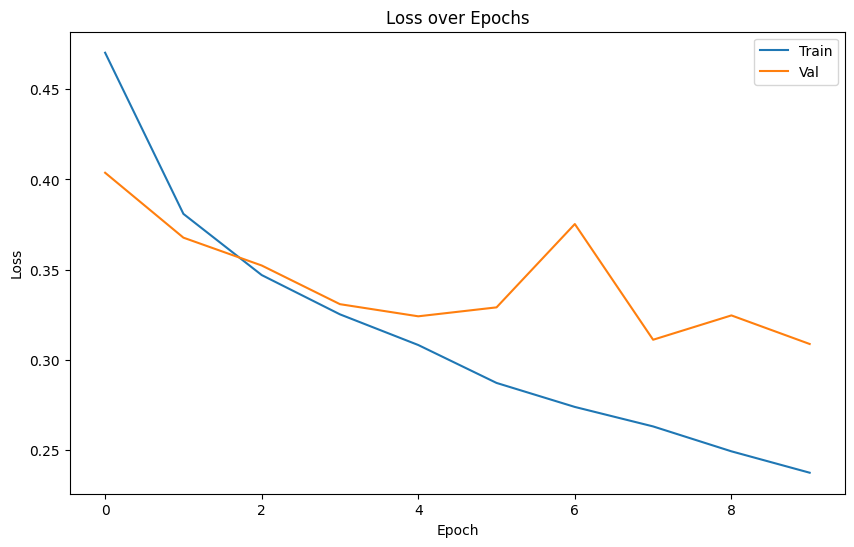

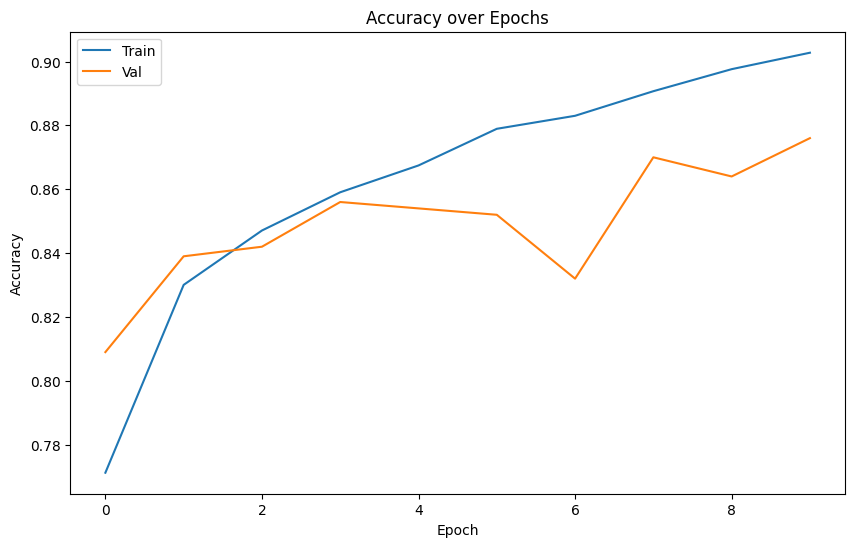

In [ ]:
def plot(epoch_train_loss,epoch_train_acc,epoch_val_loss,epoch_val_acc):
  plt.figure(figsize=(10,6))
  x_axis = range(len(epoch_train_loss))
  plt.plot(x_axis,epoch_train_loss,label="Train")
  plt.plot(x_axis,epoch_val_loss,label="Val")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss over Epochs')
  plt.legend()
  plt.show()
  plt.figure(figsize=(10,6))
  plt.plot(x_axis,epoch_train_acc,label="Train")
  plt.plot(x_axis,epoch_val_acc,label="Val")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.title('Accuracy over Epochs')
  plt.legend()
  plt.show()
print(f"Train Accuracy: {epoch_train_acc[-1]: .4f}")
print(f"Validation Accuracy: {epoch_val_acc[-1]: .4f}")
plot(epoch_train_loss,epoch_train_acc,epoch_val_loss,epoch_val_acc)

In [ ]:
embed_dim = 128
hidden_dim = 128
num_layers = 1
n_classes = 2
dropout = 0.5
model = RNNClassifier(vocab_size, embed_dim, hidden_dim, num_layers, n_classes, dropout).to(device)
model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/IMDBdataset",'rnn.pt'),weights_only=True))
train_loss, train_acc, train_f1, train_precision, train_recall = evaluate(model,train_loader,criterion,device)
print('=======Train======')
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_acc}')
print(f'Train F1 Score: {train_f1}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}\n')
print('=======Validation========')
val_loss, val_acc, val_f1, val_precision, val_recall = evaluate(model,val_loader,criterion,device)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')
print(f'Validation F1 Score: {val_f1}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}\n')
print('=======Test========')
test_loss, test_acc, test_f1, test_precision, test_recall = evaluate(model,test_loader,criterion,device)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

=======Train======
Train Loss: 0.6937884678840637
Train Accuracy: 0.5056
Train F1 Score: 0.16352254462397428
Train Precision: 0.5272776868521549
Train Recall: 0.09676611934321186

=======Validation========
Validation Loss: 0.6940784081816673
Validation Accuracy: 0.495
Validation F1 Score: 0.1455160744500846
Validation Precision: 0.6142857142857143
Validation Recall: 0.08253358925143954

=======Test========
Test Loss: 0.6933518774965977
Test Accuracy: 0.5085555555555555
Test F1 Score: 0.16720015063076635
Test Precision: 0.5495049504950495
Test Recall: 0.09860093271152565


In [ ]:
embed_dim = 128
hidden_dim = 128
num_layers = 2
dropout = 0.2
lstm_model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, num_layers, dropout).to(device)
lstm_model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/IMDBdataset",'lstm.pt'),weights_only=True))
train_loss, train_acc, train_f1, train_precision, train_recall = evaluate(lstm_model,train_loader,criterion,device)
print('=======Train======')
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_acc}')
print(f'Train F1 Score: {train_f1}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}\n')
print('=======Validation========')
val_loss, val_acc, val_f1, val_precision, val_recall = evaluate(lstm_model,val_loader,criterion,device)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')
print(f'Validation F1 Score: {val_f1}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}\n')
print('=======Test========')
test_loss, test_acc, test_f1, test_precision, test_recall = evaluate(lstm_model,test_loader,criterion,device)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

=======Train======
Train Loss: 0.11554760055831305
Train Accuracy: 0.9655555555555555
Train F1 Score: 0.9659432142769951
Train Precision: 0.9555619958460126
Train Recall: 0.9765524730970481

=======Validation========
Validation Loss: 0.34541321262507374
Validation Accuracy: 0.8757777777777778
Validation F1 Score: 0.8780274929085752
Validation Precision: 0.8613013698630136
Validation Recall: 0.8954161103693814

=======Test========
Test Loss: 0.34698284174539623
Test Accuracy: 0.8762
Test F1 Score: 0.878556013341181
Test Precision: 0.8604919292851653
Test Recall: 0.8973947895791583


In [ ]:
embed_dim = 256
num_heads = 4
num_blocks = 2
dropout=0.1
model = TransformerEncoder(vocab_size,max_seq_len,embed_dim,num_heads,num_blocks,dropout,n_classes,pad_token_id).to(device)
model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/IMDBdataset",'transformer.pt'),weights_only=True))
train_loss, train_acc, train_f1, train_precision, train_recall = evaluate(model,train_loader,criterion,device)
print('=======Train======')
print(f'Train Loss: {train_loss}')
print(f'Train Accuracy: {train_acc}')
print(f'Train F1 Score: {train_f1}')
print(f'Train Precision: {train_precision}')
print(f'Train Recall: {train_recall}\n')
print('=======Validation========')
val_loss, val_acc, val_f1, val_precision, val_recall = evaluate(model,val_loader,criterion,device)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_acc}')
print(f'Validation Accuracy: {val_acc}')
print(f'Validation F1 Score: {val_f1}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}\n')
print('=======Test========')
test_loss, test_acc, test_f1, test_precision, test_recall = evaluate(model,test_loader,criterion,device)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

=======Train======
Train Loss: 0.17011247563362122
Train Accuracy: 0.934175
Train F1 Score: 0.9351589627404142
Train Precision: 0.9203140904464155
Train Recall: 0.9504905887064478

=======Validation========
Validation Loss: 0.31486201100051403
Validation Accuracy: 0.885
Validation Accuracy: 0.885
Validation F1 Score: 0.89120151371807
Validation Precision: 0.878731343283582
Validation Recall: 0.9040307101727447

=======Test========
Test Loss: 0.3081005023832017
Test Accuracy: 0.8836666666666667
Test F1 Score: 0.8861089959751985
Test Precision: 0.8684434968017057
Test Recall: 0.9045081057073062


# **Inference**

In [ ]:
model = TransformerEncoder(vocab_size,max_seq_len,embed_dim,num_heads,num_blocks,dropout,n_classes,pad_token_id).to(device)
model.load_state_dict(torch.load(os.path.join("/content/drive/MyDrive/Colab Notebooks/IMDBdataset",'transformer.pt'),weights_only=True))
idx_2_label = {0: 'Negative', 1: 'Positive'}

def predict_sentiment(text):
    model.eval()
    clean_text = text_clean(text)
    encoded = tokenizer.encode(clean_text)
    tensor_in = torch.tensor(encoded.ids, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(tensor_in)
        probs = torch.softmax(output, dim=1)
        conf, pred_idx = torch.max(probs, dim=1)

    return idx_2_label[pred_idx.item()], conf.item()

# Test
reviews = [
    'I expected so much more. The pacing was slow and the dialogue felt unnatural.',
    'I didn’t expect much from this movie at first, but it completely surprised me. The story is heartfelt without feeling cheesy, and the character development is incredibly satisfying. The actors have amazing chemistry, and every emotional moment lands perfectly. The pacing is steady, the jokes work, and the final act ties everything together beautifully. This is the kind of film that stays with you long after the credits roll.',
    'I expected so much more based on the trailer, but the film completely failed to deliver. The story drags, the jokes fall flat, and the entire middle section feels like filler. The performances are wooden, especially the supporting cast. By the time the big reveal came, I had already lost interest. This is one of those movies that sounds better on paper than it plays on screen.',
    'There’s nothing inherently wrong with this film, but there’s nothing especially remarkable about it either. The cast does a decent job and the production value is better than expected, yet the story follows familiar beats and never tries anything new. It’s the kind of movie you might enjoy on a quiet evening, but it probably won’t leave much of an impression afterward.',
    'Terribly executed from start to finish. The premise had potential, but everything else fell apart. The acting is stiff, the pacing is erratic, and the final act is laughably bad. I rarely give harsh reviews, but this film left me frustrated and disappointed. I wouldn’t recommend it to anyone.'

]

print("\n--- INFERENCE RESULTS ---")
for r in reviews:
    label, conf = predict_sentiment(r)
    print(f"Review: {r}\n -> Predicted: {label} ({conf:.2%})\n")



--- INFERENCE RESULTS ---
Review: I expected so much more. The pacing was slow and the dialogue felt unnatural.
 -> Predicted: Negative (99.97%)

Review: I didn’t expect much from this movie at first, but it completely surprised me. The story is heartfelt without feeling cheesy, and the character development is incredibly satisfying. The actors have amazing chemistry, and every emotional moment lands perfectly. The pacing is steady, the jokes work, and the final act ties everything together beautifully. This is the kind of film that stays with you long after the credits roll.
 -> Predicted: Positive (99.22%)

Review: I expected so much more based on the trailer, but the film completely failed to deliver. The story drags, the jokes fall flat, and the entire middle section feels like filler. The performances are wooden, especially the supporting cast. By the time the big reveal came, I had already lost interest. This is one of those movies that sounds better on paper than it plays on sc